In [1]:
import pandas as pd
import textblob as tb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../datasets/nuclear_energy.csv', encoding_errors='ignore')
df.head()

,tweet_text,sentiment,sentiment_confidence_summary
0,:Hello Japan is a nuclear power plant crisis. ...,Negative,"""Neutral / author is just sharing information""..."
1,. Renewable Energy Consumption Tops Nuclear fo...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""..."
2,. Will liberals now seek to eliminate dangerou...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""..."
3,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",Neutral / author is just sharing information,"""Neutral / author is just sharing information""..."
4,[ebook] Nuclear Energy and the Environment: Ox...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""..."


In [3]:
def get_sentiment(sent_class, summary):
    summary_parts = summary.split('\n')
    for part in summary_parts:
        if sent_class in part.lower():
            sent_amount = float(part.split(':')[1])
            return sent_amount
    return None

In [4]:
df['pos'] = df['sentiment_confidence_summary'].apply(lambda x: get_sentiment('positive', x))
df['neg'] = df['sentiment_confidence_summary'].apply(lambda x: get_sentiment('negative', x))
df.head()

,tweet_text,sentiment,sentiment_confidence_summary,pos,neg
0,:Hello Japan is a nuclear power plant crisis. ...,Negative,"""Neutral / author is just sharing information""...",NaN,0.800
1,. Renewable Energy Consumption Tops Nuclear fo...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",NaN,NaN
2,. Will liberals now seek to eliminate dangerou...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",NaN,0.333
3,"(Aug 22,2011)Plant Status of Fukushima Daiichi...",Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",NaN,NaN
4,[ebook] Nuclear Energy and the Environment: Ox...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",NaN,NaN


In [5]:
df_filtered = df.dropna(how='all', subset=['pos', 'neg']).fillna(0)
df_filtered.head()

,tweet_text,sentiment,sentiment_confidence_summary,pos,neg
0,:Hello Japan is a nuclear power plant crisis. ...,Negative,"""Neutral / author is just sharing information""...",0.0,0.800
2,. Will liberals now seek to eliminate dangerou...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",0.0,0.333
6,[news] Nuclear Power Plant: Radioactive Tritiu...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",0.0,0.143
9,{link} &quot;The right thing to do&quot; I'm f...,Positive,"""Neutral / author is just sharing information""...",0.6,0.200
11,{link} 74 percent favor gradual reduction of n...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",0.0,0.200


In [6]:
df_filtered['polarity'] = [tb.TextBlob(t).sentiment.polarity for t in df_filtered['tweet_text']]
df_filtered.head()

,tweet_text,sentiment,sentiment_confidence_summary,pos,neg,polarity
0,:Hello Japan is a nuclear power plant crisis. ...,Negative,"""Neutral / author is just sharing information""...",0.0,0.800,0.000000
2,. Will liberals now seek to eliminate dangerou...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",0.0,0.333,-0.400000
6,[news] Nuclear Power Plant: Radioactive Tritiu...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",0.0,0.143,0.000000
9,{link} &quot;The right thing to do&quot; I'm f...,Positive,"""Neutral / author is just sharing information""...",0.6,0.200,0.142857
11,{link} 74 percent favor gradual reduction of n...,Neutral / author is just sharing information,"""Neutral / author is just sharing information""...",0.0,0.200,0.000000


In [7]:
def evaluate(fn, polarities, amounts):
    a, b = fn

    if b < a:
        return 10000

    sse = 0
    for x, y in zip(polarities, amounts):
        if x < a:
            sse += y ** 2
        elif x > b:
            sse += (1 - y) ** 2
        else:
            expected = (x - a) / (b - a)
            sse += (expected - y) ** 2

    return sse / len(polarities)

In [8]:
def find_best(polarities, amounts):
    top_result = 100000  # Some very high initial average SSE
    top_config = -1.0, -1.0  # Both `a` and `b` will be set to -1 at the start

    #  `a` will assume values from -1 to 1 with step size 0.01
    for a_base in range(-100, 100):
        a = a_base / 100

        # `b` will assume values from `a` to 1, but it won't go under 0
        for b_base in range(max(a_base + 1, 0, 100)):
            b = b_base / 100

            result = evaluate((a, b), polarities, amounts)
            if result < top_result:
                top_result = result
                top_config = a, b
    
    return top_result, top_config

In [9]:
sse_pos, fn_pos = find_best(df_filtered['polarity'].values, df_filtered['pos'].values)
print(f'Positive sentiment: SSE = {sse_pos:.4f}; a = {fn_pos[0]}; b = {fn_pos[1]}')

sse_neg, fn_neg = find_best(-1 * df_filtered['polarity'].values, df_filtered['neg'].values)
print(f'Negative sentiment: SSE = {sse_neg:.4f}; a = {-1 * fn_neg[0]}; b = {-1 * fn_neg[1]}')

/tmp/ipykernel_32053/2603155445.py:14: RuntimeWarning: invalid value encountered in scalar divide
  expected = (x - a) / (b - a)


Positive sentiment: SSE = 0.0514; a = 0.33; b = 0.99
Negative sentiment: SSE = 0.1064; a = 0.52; b = -0.99


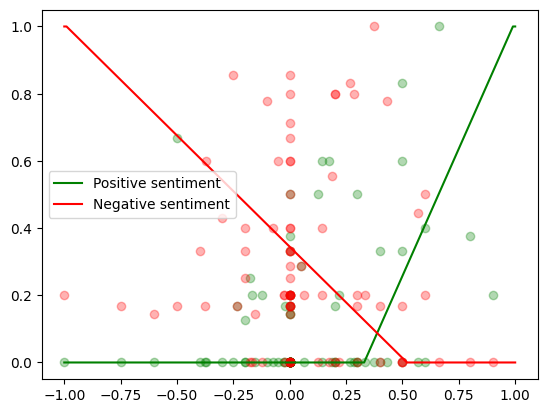

In [10]:
plt.plot([-1, fn_pos[0], fn_pos[1], 1], [0, 0, 1, 1], color='green', label='Positive sentiment')
plt.plot([-1, -1 * fn_neg[1], -1 * fn_neg[0], 1], [1, 1, 0, 0], color='red', label='Negative sentiment')
plt.scatter(df_filtered['polarity'], df_filtered['pos'], color='green', alpha=0.3)
plt.scatter(df_filtered['polarity'], df_filtered['neg'], color='red', alpha=0.3)
plt.legend()


In [20]:
df_airlines = pd.read_csv('../datasets/airlines.csv', encoding_errors='ignore', delimiter=';')
df_airlines = df_airlines[['airline_sentiment', 'airline_sentiment_confidence', 'Sla sentimentu', 'text']]
df_airlines = df_airlines.rename(columns={'Sla sentimentu': 'sentiment_strength'})
df_airlines.head()

,airline_sentiment,airline_sentiment_confidence,sentiment_strength,text
0,negative,1.0000,3.0,@VirginAmerica it's really aggressive to blast...
1,negative,1.0000,3.0,@VirginAmerica and it's a really big bad thing...
2,negative,1.0000,3.0,@VirginAmerica seriously would pay $30 a fligh...
3,negative,0.6842,2.0,@VirginAmerica SFO-PDX schedule is still MIA.
4,negative,1.0000,3.0,@VirginAmerica I flew from NYC to SFO last we...


In [23]:
strength_max = df_airlines['sentiment_strength'].max()
strength_max

3.0

In [28]:
df_airlines['sentiment_strength_normalized'] = df_airlines['sentiment_strength'].apply(lambda x: x / strength_max)
df_airlines['polarity'] = [tb.TextBlob(t).sentiment.polarity if type(t) == str else None for t in df_airlines['text']]
df_airlines = df_airlines.dropna()
df_airlines.head()

,airline_sentiment,airline_sentiment_confidence,sentiment_strength,text,sentiment_strength_normalized,polarity
0,negative,1.0000,3.0,@VirginAmerica it's really aggressive to blast...,1.000000,0.200000
1,negative,1.0000,3.0,@VirginAmerica and it's a really big bad thing...,1.000000,-0.350000
2,negative,1.0000,3.0,@VirginAmerica seriously would pay $30 a fligh...,1.000000,-0.333333
3,negative,0.6842,2.0,@VirginAmerica SFO-PDX schedule is still MIA.,0.666667,0.000000
4,negative,1.0000,3.0,@VirginAmerica I flew from NYC to SFO last we...,1.000000,0.047619


In [32]:
df_airlines_positive = df_airlines[df_airlines['airline_sentiment'] == 'positive']
sse_pos_airlines, fn_pos_airlines = find_best(df_airlines_positive['polarity'].values, df_airlines_positive['airline_sentiment_confidence'].values)
print(f'Positive sentiment: SSE = {sse_pos_airlines:.4f}; a = {fn_pos_airlines[0]}; b = {fn_pos_airlines[1]}')

df_airlines_negative = df_airlines[df_airlines['airline_sentiment'] == 'negative']
sse_neg_airlines, fn_neg_airlines = find_best(df_airlines_negative['polarity'].values * -1, df_airlines_negative['airline_sentiment_confidence'].values)
print(f'Negative sentiment: SSE = {sse_pos_airlines:.4f}; a = {fn_neg_airlines[0]}; b = {fn_neg_airlines[1]}')

/tmp/ipykernel_32053/2603155445.py:14: RuntimeWarning: invalid value encountered in scalar divide
  expected = (x - a) / (b - a)


Positive sentiment: SSE = 0.0383; a = -1.0; b = 0.33
Negative sentiment: SSE = 0.0383; a = -1.0; b = 0.0


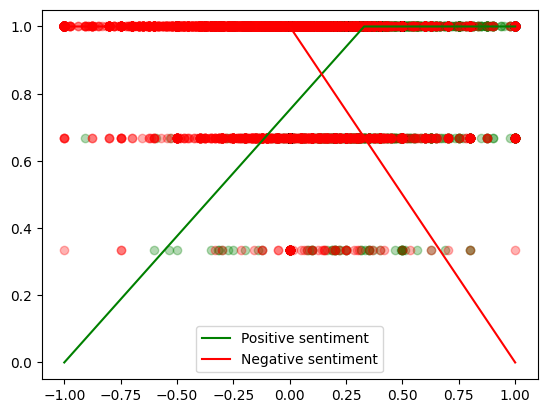

In [33]:
plt.plot([-1, fn_pos_airlines[0], fn_pos_airlines[1], 1], [0, 0, 1, 1], color='green', label='Positive sentiment')
plt.plot([-1, -1 * fn_neg_airlines[1], -1 * fn_neg_airlines[0], 1], [1, 1, 0, 0], color='red', label='Negative sentiment')
plt.scatter(df_airlines_positive['polarity'], df_airlines_positive['sentiment_strength_normalized'], color='green', alpha=0.3)
plt.scatter(df_airlines_negative['polarity'], df_airlines_negative['sentiment_strength_normalized'], color='red', alpha=0.3)
plt.legend()


In [38]:
df_weather = pd.read_csv('../datasets/weather.csv', encoding_errors='ignore')
df_weather = df_weather[['what_emotion_does_the_author_express_specifically_about_the_weather', 'what_emotion_does_the_author_express_specifically_about_the_weather:confidence', 'tweet_text']]
df_weather.columns = ['sentiment', 'confidence', 'tweet_text']
df_weather.head()

,sentiment,confidence,tweet_text
0,Positive,0.8439,Grilling kabobs on the grill last night was am...
1,Negative,0.6963,The slowest day ever !! And the weather makes ...
2,Neutral / author is just sharing information,0.8802,Fire Weather Watch issued May 17 at 4:21PM CDT...
3,Positive,0.6897,Im going to lunch early today. The weather i...
4,Neutral / author is just sharing information,0.6153,Weekend Weather Causes Delays In I-270 Bridge ...


In [45]:
df_weather['polarity'] = [tb.TextBlob(t).sentiment.polarity if type(t) == str else None for t in df_weather['tweet_text']]
df_weather = df_weather[df_weather['polarity'].abs() > 0.05]
df_weather.head()

,sentiment,confidence,tweet_text,polarity
0,Positive,0.8439,Grilling kabobs on the grill last night was am...,0.312500
1,Negative,0.6963,The slowest day ever !! And the weather makes ...,-0.500000
3,Positive,0.6897,Im going to lunch early today. The weather i...,0.388889
5,Positive,0.6365,Passing out now. working tonight. Storms toda...,0.700000
6,Neutral / author is just sharing information,0.5582,US GAS: Warm-Weather Forecasts Lift Natural Ga...,0.100000


In [46]:
df_weather_positive = df_weather[df_weather['sentiment'] == 'Positive']
sse_pos_weather, fn_pos_weather = find_best(df_weather_positive['polarity'].values, df_weather_positive['confidence'].values)
print(f'Positive sentiment: SSE = {sse_pos_weather:.4f}; a = {fn_pos_weather[0]}; b = {fn_pos_weather[1]}')

df_weather_negative = df_weather[df_weather['sentiment'] == 'Negative']
sse_neg_weather, fn_neg_weather = find_best(-1 * df_weather_negative['polarity'].values, df_weather_negative['confidence'].values)
print(f'Negative sentiment: SSE = {sse_neg_weather:.4f}; a = {-1 * fn_neg_weather[0]}; b = {-1 * fn_neg_weather[1]}')

/tmp/ipykernel_32053/2603155445.py:14: RuntimeWarning: invalid value encountered in scalar divide
  expected = (x - a) / (b - a)


Positive sentiment: SSE = 0.0474; a = -0.96; b = 0.99
Negative sentiment: SSE = 0.0634; a = 1.0; b = -0.89


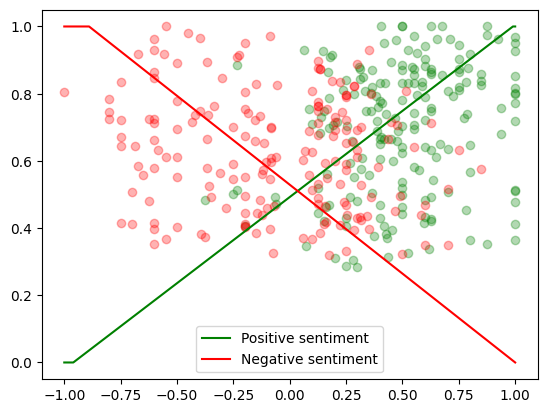

In [47]:
plt.plot([-1, fn_pos_weather[0], fn_pos_weather[1], 1], [0, 0, 1, 1], color='green', label='Positive sentiment')
plt.plot([-1, -1 * fn_neg_weather[1], -1 * fn_neg_weather[0], 1], [1, 1, 0, 0], color='red', label='Negative sentiment')
plt.scatter(df_weather_positive['polarity'], df_weather_positive['confidence'], color='green', alpha=0.3)
plt.scatter(df_weather_negative['polarity'], df_weather_negative['confidence'], color='red', alpha=0.3)
plt.legend()